In [187]:
import os
#import os
import time
import gc
import argparse
import requests
import shutil
import io

#Data Science Libraries
import pandas as pd
import numpy as np

#Import Math, Systems and Date Libraries
import math
import sys
import warnings
import datetime
import pickle

#Google Cloud Libraries
from google.cloud import bigquery as bq
from google.cloud import storage

In [188]:
#Change if you are using a different project
%env GOOGLE_CLOUD_PROJECT= 'a-better-mistake-2021'

env: GOOGLE_CLOUD_PROJECT='a-better-mistake-2021'


In [189]:
def bq_job_config(start_date,end_date):
    
    job_config = bq.QueryJobConfig()
    return job_config

In [190]:
def generate_sql(sql_,project_id,start_date,end_date):
    
    client = bq.Client(project=project_id)
    job_config = bq_job_config(start_date,end_date)
    print(job_config)
    try:
        print("Try Block")
        query = client.query(sql_,job_config=job_config)
    except:
        print("Error in query")
    return query

In [191]:
def create_bqml_model(sql_statement):
    """Executes a BigQuery SQL query and creates a BQML model.

    Args:
        sql_statement (str): The SQL query to execute.

    Returns:
        model creation output
    """

    # Create a BigQuery client
    client = bq.Client(project="a-better-mistake-2021")

    # Execute the query and wait for results
    query_job = client.query(sql_statement)  
    results = query_job.result()  

    # Convert the results to a pandas DataFrame
    return results

In [192]:
def read_bigquery_data(sql_statement):
    # Set up BigQuery client
    client = bq.Client(project="a-better-mistake-2021")

    # Run the SQL query
    query_job = client.query(sql_statement)

    # Convert query results to a pandas DataFrame
    dataframe = query_job.to_dataframe()

    return dataframe

In [193]:
def execute_query_to_dataframe(sql_statement):
    """Executes a BigQuery SQL query and returns the results as a pandas DataFrame.

    Args:
        sql_statement (str): The SQL query to execute.

    Returns:
        pandas.DataFrame: The results of the BigQuery query.
    """

    # Create a BigQuery client
    client = bq.Client()

    # Execute the query and wait for results
    query_job = client.query(sql_statement)  
    results = query_job.result()  

    # Convert the results to a pandas DataFrame
    return results.to_dataframe()

In [194]:
def get_data(sql_, project_id, start_date, end_date):

    client = bq.Client(project=project_id)
    job_config = bq_job_config(start_date,end_date)
    try:
        df = client.query(sql_,job_config=job_config)
    except:
        print("Error getting data")
    
    df = df.to_dataframe(progress_bar_type='tqdm') # Converts to dataframe
    
    return df

In [195]:
def add_to_table(dest_table_id, sql,bq_table_exists=True):
    
    # Construct a BigQuery client object.
    client = bq.Client()
    
    if bq_table_exists:
        write_disposition = "WRITE_TRUNCATE"
    else:
        write_disposition = "WRITE_EMPTY"
    
    job_config = bq.QueryJobConfig(
        # Set our destination table
        destination=dest_table_id,
        
        # setting to add to the destination table if it already exists 
        write_disposition= write_disposition,
        create_disposition='CREATE_IF_NEEDED'
    )
    
    query_job = client.query(sql, job_config=job_config, )  # Make an API request.
    query_job.result() # Wait for result

    return

In [196]:
def load_dataframe_to_bigquery(dataframe,table_id,job_config):
    bq_job = bq_client.load_table_from_dataframe(
    vision_df, table_id, job_config=bq_job_config
    )  # Make an API request.
    return bq_job.result() 

In [197]:
def read_data(filename,num_rows):
    df = pd.read_csv(filename,nrows=num_rows,delimiter="|")
    return df

In [198]:
def create_gcp_bucket(client,bucket_name):
    storage_client = client
    bucket = storage_client.bucket(bucket_name)
    return bucket

In [199]:
def create_bigquery_table(dataframe, project_id, dataset_id, table_id):
    # Initialize BigQuery client
    client = bq.Client(project=project_id)

    # Create dataset if it doesn't exist
    dataset_ref = client.dataset(dataset_id)
    dataset = bq.Dataset(dataset_ref)
    dataset.location = "US"
    dataset = client.create_dataset(dataset, exists_ok=True)

    # Convert DataFrame to BigQuery table
    table_ref = dataset.table(table_id)
    print(table_ref)
    job_config = bq.LoadJobConfig()
    job_config.write_disposition = bq.WriteDisposition.WRITE_TRUNCATE
    job = client.load_table_from_dataframe(dataframe, table_ref, job_config=job_config)
    job.result()

    print(f"Table {table_id} created successfully in BigQuery.")

In [200]:
#Environment ARIMA Variables
PROJECT_ID = "a-better-mistake-2021"
dataset_id = "aster_uat"
training_table_id = "sku_arima_regression_quantity_training_data"
evaluation_table_id = "sku_arima_regression_quantity_evaluation_data"
prediction_table_id = "sku_arima_regression_quantity_prediction_data"

In [90]:
#ARIMA Training Data
SKU_TRAINING_CREATION_SQL_PATH = "sql/arima/quantity/arima_training_quantity_data.sql"

In [91]:
#ARIMA Training Data
CREATE_ARIMA_SQL_PATH = "sql/arima/quantity/create_arima_quantity_model.sql"

In [92]:
#Create SKU Training Table
train_sql_query = open(SKU_TRAINING_CREATION_SQL_PATH).read()

In [93]:
#Create ARIMA Dataframe
train_df = read_bigquery_data(train_sql_query)
train_df.head()

,date,item_id,store_id,quantity
0,2024-01-02,1000111,1278,1.0
1,2024-01-02,1000314,1278,1.0
2,2024-01-02,1001151,1278,2.0
3,2024-01-02,1001417,1278,1.0
4,2024-01-02,1002429,1278,1.0


In [94]:
#Create Training Data for ARIMA+ Model
create_bigquery_table(train_df, PROJECT_ID, dataset_id, training_table_id)

a-better-mistake-2021.aster_uat.sku_arima_regression_quantity_training_data
Table sku_arima_regression_quantity_training_data created successfully in BigQuery.


In [95]:
#Read ARIMA Model
create_arima_model_query = open(CREATE_ARIMA_SQL_PATH).read()

In [96]:
#Create ARIMA Model
create_bqml_model(create_arima_model_query)

In [99]:
#Evaluation Results
ARIMA_EVALUATION_SQL_PATH = "sql/arima/quantity/arima_evaluation_data.sql"

In [100]:
arima_evaluation_query = open(ARIMA_EVALUATION_SQL_PATH).read()

In [101]:
#Create Dataframe
arima_eval_df = read_bigquery_data(arima_evaluation_query)
arima_eval_df.head()

,date,real_quantity,upper_forecast,avg_forecast,lower_forecast
0,2024-12-11,1177.0,4193.4,3031.5,1869.8
1,2024-12-12,1470.0,4320.1,2940.1,1560.4
2,2024-12-13,1354.0,3905.8,2675.4,1444.8
3,2024-12-14,1384.0,4421.4,2970.1,1518.3
4,2024-12-15,1459.0,4351.1,2905.8,1460.1


In [102]:
import matplotlib.pyplot as plt

In [103]:
#ARIMA forecast
# Create the plot
plt.figure(figsize=(10, 6)) 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

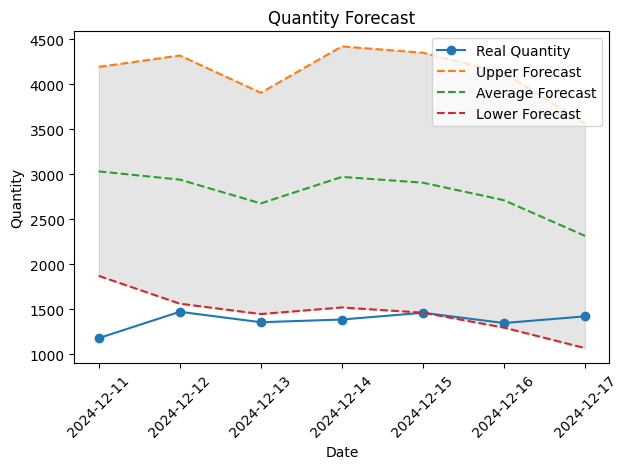

In [104]:
# Plot the lines
plt.plot(arima_eval_df['date'], arima_eval_df['real_quantity'], label='Real Quantity', marker='o')
plt.plot(arima_eval_df['date'], arima_eval_df['upper_forecast'], label='Upper Forecast', linestyle='--')
plt.plot(arima_eval_df['date'], arima_eval_df['avg_forecast'], label='Average Forecast', linestyle='--')
plt.plot(arima_eval_df['date'], arima_eval_df['lower_forecast'], label='Lower Forecast', linestyle='--')

# Fill between the forecast lines
plt.fill_between(arima_eval_df['date'], arima_eval_df['lower_forecast'], arima_eval_df['upper_forecast'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity Forecast')
plt.legend()

# Format the x-axis (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [147]:
#Save ARIMA Prediction Table to BigQuery
SKU_ARIMA_PREDICITION_PATH = "sql/arima/quantity/arima_prediction_data.sql"

In [149]:
arima_prediction_data_query = open(SKU_ARIMA_PREDICITION_PATH).read()

In [150]:
#Create Regression Evaluation Dataframe
arima_preds_df = read_bigquery_data(arima_prediction_data_query)
arima_preds_df.head()

,date,store_id,item_id,upper_forecast,avg_forecast,lower_forecast
0,2024-12-11,1278,1053508,6.0,5.5,5.0
1,2024-12-11,1278,1057634,4.9,4.6,4.3
2,2024-12-11,1278,1004033,3.1,2.3,1.5
3,2024-12-11,1278,1004157,5.8,4.0,2.1
4,2024-12-11,1304,1023471,4.1,2.4,0.6


In [153]:
#Create Prediction Data for Arima Model in BigQuery
create_bigquery_table(arima_preds_df, PROJECT_ID, dataset_id, prediction_table_id)

a-better-mistake-2021.aster_uat.sku_arima_regression_quantity_prediction_data
Table sku_arima_regression_quantity_prediction_data created successfully in BigQuery.


In [145]:
#Regression Project Variables
PROJECT_ID = "a-better-mistake-2021"
dataset_id = "aster_uat"
regression_training_table_id = "sku_regression_quantity_training_data"
regression_evaluation_table_id = "sku_regression_quantity_evaluation_data"
regression_prediction_table_id = "sku_regression_quantity_prediction_data"

In [106]:
#Create Training Data for XGBoost Regression Model
SKU_REGRSSION_TRAINING_CREATION_SQL_PATH = "sql/regression/quantity/regression_training_data.sql"

In [107]:
regression_training_data_sql = open(SKU_REGRSSION_TRAINING_CREATION_SQL_PATH).read()

In [108]:
#Create Regression Dataframe
regression_train_df = read_bigquery_data(regression_training_data_sql)
regression_train_df.head()

,date,day_of_week,delivery_type,item_id,store_id,item_discount,quantity
0,2024-01-02,3,Standard,1000111,1278,0.0,1.0
1,2024-01-02,3,Standard,1000314,1278,0.0,1.0
2,2024-01-02,3,Standard,1001151,1278,0.0,2.0
3,2024-01-02,3,Standard,1001417,1278,0.0,1.0
4,2024-01-02,3,Standard,1002429,1278,0.0,1.0


In [109]:
#Create BigQuery Table for Regression training data
create_bigquery_table(regression_train_df, PROJECT_ID, dataset_id, regression_training_table_id)

a-better-mistake-2021.aster_uat.sku_regression_quantity_training_data
Table sku_regression_quantity_training_data created successfully in BigQuery.


In [110]:
#Create BigQuery XGBoost Model Query
CREATE_REGRESSION_SQL_PATH = "sql/regression/quantity/create_regression_model.sql"

In [111]:
#Create SKU Training Table
create_regression_sql_query = open(CREATE_REGRESSION_SQL_PATH).read()

In [112]:
#Create XGBoost Model
create_bqml_model(create_arima_model_query)

In [132]:
#Evaluation query
SKU_REGRESSION_EVALUATION_CREATION_SQL_PATH = "sql/regression/quantity/regression_evaluation_data.sql"

In [133]:
regression_evaluation_sql_query = open(SKU_REGRESSION_EVALUATION_CREATION_SQL_PATH).read()

In [134]:
#Create Regression Evaluation Dataframe
regression_eval_df = read_bigquery_data(regression_evaluation_sql_query)
regression_eval_df.head()

,date,predicted_quantity,real_quantity
0,2024-12-11,1007.0,1177.0
1,2024-12-12,1350.0,1470.0
2,2024-12-13,1246.0,1354.0
3,2024-12-14,1305.0,1384.0
4,2024-12-15,1346.0,1459.0


In [135]:
#Visual Model Results
#Create the plot
plt.figure(figsize=(10, 6)) 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

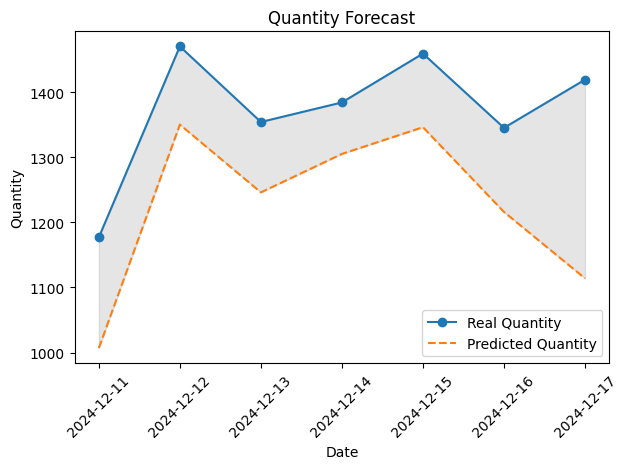

In [137]:
# Plot the lines
plt.plot(regression_eval_df['date'], regression_eval_df['real_quantity'], label='Real Quantity', marker='o')
plt.plot(regression_eval_df['date'], regression_eval_df['predicted_quantity'], label='Predicted Quantity', linestyle='--')

# Fill between the forecast lines
plt.fill_between(regression_eval_df['date'], regression_eval_df['real_quantity'], regression_eval_df['predicted_quantity'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity Forecast')
plt.legend()

# Format the x-axis (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [140]:
#Save Regression Prediction Table to BigQuery
SKU_REGRESSION_PREDICITION_PATH = "sql/regression/quantity/regression_prediction_query.sql"

In [143]:
regression_prediction_query = open(SKU_REGRESSION_PREDICITION_PATH).read()

In [144]:
#Create Regression Evaluation Dataframe
regression_preds_df = read_bigquery_data(regression_prediction_query)
regression_preds_df.head()

,date,item_id,store_id,predicted_quantity
0,2024-12-11,1004156,1278,5.0
1,2024-12-11,1023001,1278,3.0
2,2024-12-11,1007331,1278,5.0
3,2024-12-11,1008449,1205,4.0
4,2024-12-11,1008449,1278,5.0


In [146]:
#Create Prediction Data for Regression Model
create_bigquery_table(regression_preds_df, PROJECT_ID, dataset_id, regression_prediction_table_id)

a-better-mistake-2021.aster_uat.sku_regression_quantity_prediction_data
Table sku_regression_quantity_prediction_data created successfully in BigQuery.


In [167]:
#Blended Model Table ID
blended_model_predictions_table_id = "blended_predictions"

In [168]:
#Create a blended Model Approach
SKU_BLENDED_MODEL_PREDICTION_PATH = "sql/blended/quantity/blended_model_preds.sql"

In [169]:
blended_prediction_query = open(SKU_BLENDED_MODEL_PREDICTION_PATH).read()

In [170]:
blended_preds_df = read_bigquery_data(blended_prediction_query)
blended_preds_df.head()

,date,item_id,store_id,regression_preds,upper_forecast,avg_forecast,lower_forecast,blended_avg_forecast,blended_lower_forecast,blended_upper_forecast
0,2024-12-11,1002020,1278,2.0,3.9,2.7,1.6,2.35,1.8,2.95
1,2024-12-11,1002020,1278,2.0,3.9,2.7,1.6,2.35,1.8,2.95
2,2024-12-11,1004156,1119,2.0,8.0,3.6,-0.8,2.80,0.6,5.00
3,2024-12-11,1004156,1213,2.0,6.9,3.1,-0.6,2.55,0.7,4.45
4,2024-12-11,1005934,1278,2.0,4.0,3.0,2.0,2.50,2.0,3.00


In [171]:
#Save Blended Predictions to BigQuery Table
create_bigquery_table(blended_preds_df , PROJECT_ID, dataset_id, blended_model_predictions_table_id )

a-better-mistake-2021.aster_uat.blended_predictions
Table blended_predictions created successfully in BigQuery.


In [172]:
#Evaluate Blended Model
blended_model_evaluation_table_id = "blended_evaluation"

In [173]:
#Create blended model path 
BLENDED_MODEL_EVALUATION_PATH = "sql/blended/quantity/blended_model_eval.sql"

In [174]:
blended_evaluation_query = open(BLENDED_MODEL_EVALUATION_PATH).read()

In [175]:
blended_eval_df = read_bigquery_data(blended_evaluation_query)
blended_eval_df.head()

,date,real_quantity,regression_preds,upper_forecast,avg_forecast,lower_forecast,blended_avg_forecast,blended_lower_forecast,blended_upper_forecast
0,2024-12-11,1177.0,853.0,1189.0,869.0,551.0,861.0,702.0,1021.0
1,2024-12-12,1470.0,1172.0,1587.0,1169.0,742.0,1171.0,957.0,1379.0
2,2024-12-13,1354.0,1064.0,1338.0,970.0,597.0,1017.0,830.0,1201.0
3,2024-12-14,1384.0,1070.0,1376.0,983.0,589.0,1026.0,830.0,1223.0
4,2024-12-15,1459.0,1091.0,1545.0,1083.0,624.0,1087.0,858.0,1318.0


In [177]:
#Save blended evaluation to BigQuery Table
create_bigquery_table(blended_preds_df , PROJECT_ID, dataset_id, blended_model_evaluation_table_id  )

a-better-mistake-2021.aster_uat.blended_evaluation
Table blended_evaluation created successfully in BigQuery.


In [185]:
# Create the plot
plt.figure(figsize=(100, 60)) 

<Figure size 10000x6000 with 0 Axes>

<Figure size 10000x6000 with 0 Axes>

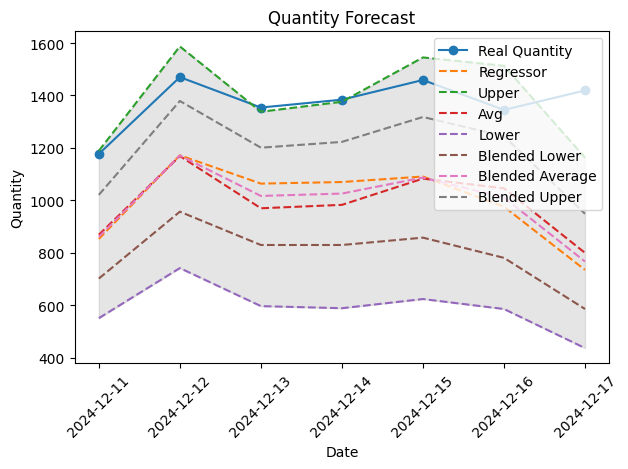

In [186]:
# Plot the lines
plt.plot(blended_eval_df['date'], blended_eval_df['real_quantity'], label='Real Quantity', marker='o')
plt.plot(blended_eval_df['date'], blended_eval_df['regression_preds'], label='Regressor', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['upper_forecast'], label='Upper', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['avg_forecast'], label='Avg', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['lower_forecast'], label='Lower', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['blended_lower_forecast'], label='Blended Lower', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['blended_avg_forecast'], label='Blended Average', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['blended_upper_forecast'], label='Blended Upper', linestyle='--')

# Fill between the forecast lines
plt.fill_between(blended_eval_df['date'], blended_eval_df['lower_forecast'], blended_eval_df['upper_forecast'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity Forecast')
plt.legend()

# Format the x-axis (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()